In [1]:
# hide warnings messages
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

In [2]:
# import and setup mlflow library
import mlflow
import mlflow.xgboost

# mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 315, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 408, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1336, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1329, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 309, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does n

<Experiment: artifact_location='file:///workspaces/mlops-course/module_2/mlruns/216665436346368280', creation_time=1716473206979, experiment_id='216665436346368280', last_update_time=1716473206979, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
# import xgboost
import xgboost as xgb

# import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
# read the data
def read_data(filepath):
    """
    Read the parquet file and return the dataframe
    """
    # read parquet file
    df = pd.read_parquet(filepath)

    # calculate the duration of the trip in minutes then round to two decimal places
    df['duration'] = ((df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60)

    # filter for trips that are between 1 and 60 minutes
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    # create a new column for the pickup and dropoff location
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)

    return df

In [5]:
# train the model
def train_model(df_train, df_val, model):
    """
    Train the model and return the predictions
    """
    # feature selection
    categorical_features = ['PU_DO']
    numerical_features = ['trip_distance']

    # convert the categorical features to string
    df_train[categorical_features] = df_train[categorical_features].astype(str)

    # initialize the DictVectorizer
    dv = DictVectorizer()

    # training data
    train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    # validation data
    val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)    

    # target variable
    y_train = df_train['duration'].values
    y_val = df_val['duration'].values

    # train the model
    model.fit(X_train, y_train)

    # predict the duration of the trip
    y_pred = model.predict(X_val)

    return y_pred, y_val, model, dv, X_val, X_train, y_train

In [6]:
def check_distribution(y_pred, y_val):
    """
    Check the distribution of the predictions and the actual values
    """
    sns.distplot(y_pred, label = 'Predictions')
    sns.distplot(y_val, label = 'Actual')
    plt.legend()
    plt.show()

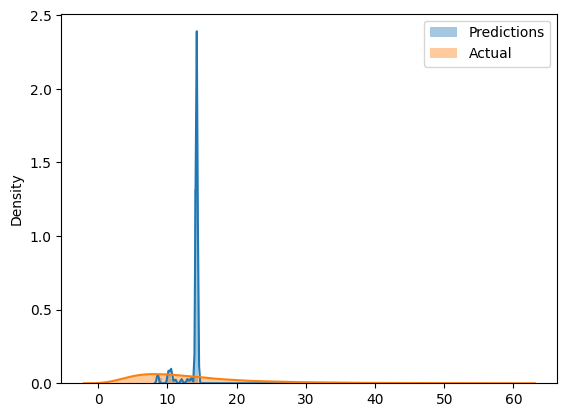

In [7]:
# read the data
df_train = read_data('./data/green_tripdata_2023-01.parquet')
df_val = read_data('./data/green_tripdata_2023-02.parquet')

# run the experiment
with mlflow.start_run():
    # log the parameters, add tags
    mlflow.set_tag("Developer", "Nazmul")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")

    # log the alpha value
    alpha_tuning = 0.05
    mlflow.log_param("alpha", alpha_tuning)

    # train the model
    y_pred, y_val, model, dv, X_val, X_train, y_train = train_model(df_train, df_val, Lasso(alpha=alpha_tuning))

    # calculate mean squared error of RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_artifact(local_path="models/las_reg.bin", artifact_path="models_artifact")

# check the distribution
check_distribution(y_pred, y_val)

In [8]:
# check the number of rows in the training and validation set
len(df_train), len(df_val)

(65946, 62574)

In [9]:
# export the model and the DictVectorizer
with open('./models/las_reg.bin', 'wb') as f:
    pickle.dump((dv, model), f)

In [10]:
# export the training and validation data
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [11]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [12]:
# # define the search space
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),  # exp(-3), exp(0) -> [0.05, 1]
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42,
# }

# # run the hyperparameter optimization
# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [13]:
# params = {
#     'learning_rate' : 0.11639247400319915, 
#     'reg_lambda' : 0.14226124968206577, 
#     'min_child_weight' : 3.8406996521946293,
#     'reg_alpha' : 0.039496945697022334,
#     'max_depth' : 18,
#     'objective' : 'reg:linear',
#     'seed' : 42
# }

# mlflow.xgboost.autolog()

# booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1000,
#             evals=[(valid, "validation")],
#             early_stopping_rounds=50
# )

In [16]:
with mlflow.start_run():

    params = {
        'learning_rate' : 0.11639247400319915, 
        'reg_lambda' : 0.14226124968206577, 
        'min_child_weight' : 3.8406996521946293,
        'reg_alpha' : 0.039496945697022334,
        'max_depth' : 18,
        'objective' : 'reg:linear',
        'seed' : 42
    }

    mlflow.log_params(params)

    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, "validation")],
                early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:8.62764
[1]	validation-rmse:8.04277
[2]	validation-rmse:7.55221
[3]	validation-rmse:7.14570
[4]	validation-rmse:6.80884
[5]	validation-rmse:6.53052
[6]	validation-rmse:6.30468
[7]	validation-rmse:6.11687
[8]	validation-rmse:5.96274
[9]	validation-rmse:5.83831
[10]	validation-rmse:5.73736
[11]	validation-rmse:5.65648
[12]	validation-rmse:5.58881
[13]	validation-rmse:5.53512
[14]	validation-rmse:5.48998
[15]	validation-rmse:5.45357
[16]	validation-rmse:5.42348
[17]	validation-rmse:5.39721
[18]	validation-rmse:5.37497
[19]	validation-rmse:5.35783
[20]	validation-rmse:5.34388
[21]	validation-rmse:5.33039
[22]	validation-rmse:5.31935
[23]	validation-rmse:5.30956
[24]	validation-rmse:5.30168
[25]	validation-rmse:5.29538
[26]	validation-rmse:5.28926
[27]	validation-rmse:5.28500
[28]	validation-rmse:5.27946
[29]	validation-rmse:5.27617
[30]	validation-rmse:5.27358
[31]	validation-rmse:5.26883
[32]	validation-rmse:5.26683
[33]	validation-rmse:5.26431
[34]	validation-rmse:5.2

In [19]:
logged_model = 'runs:/011c0a04bf1045d791de5d3eac046d56/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [20]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 011c0a04bf1045d791de5d3eac046d56

In [21]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [22]:
xgboost_model

In [23]:
y_pred = xgboost_model.predict(valid)

In [24]:
y_pred[:10]

array([22.488533 , 21.612494 , 24.829329 , 18.952093 , 14.050298 ,
       13.330441 , 13.002602 ,  7.4888716, 13.50657  , 11.142972 ],
      dtype=float32)